In [1]:
#https://www.kaggle.com/code/vmarkin/advatt
# carregar as bibliotecas básicas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline

In [2]:
train_data_path = '../dataset/X_train_sat6.csv'
train_label_path = '../dataset/y_train_sat6.csv'
test_data_path = '../dataset/X_test_sat6.csv'
test_label_path = '../dataset/y_test_sat6.csv'
# train_qtdy = 10000
# test_qtdy = 2048     
train_qtdy = 324000
test_qtdy = 81000     

In [3]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows, dtype=np.uint8)
    data=data.values ## converting the data into numpy array
    return data

In [4]:
train_data=data_read(train_data_path, nrows=train_qtdy)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=train_qtdy)
print("Train data label shape:" + str(train_data_label.shape))

##Read test data
test_data=data_read(test_data_path, nrows=test_qtdy)
print("Test data shape:" + str(test_data.shape))

##Read test data labels
test_data_label=data_read(test_label_path,nrows=test_qtdy)
print("Test data label shape:" + str(test_data_label.shape))

Train data shape:(324000, 3136)
Train data label shape:(324000, 6)
Test data shape:(81000, 3136)
Test data label shape:(81000, 6)


In [5]:
example = train_data[0]
print(example.shape)
reshaped_ex = example.reshape((28,28,4))[:,:,:3] #convert to rgb 

ex = np.zeros((32, 32, 3),dtype=np.int32)
ex[:28, :28, :] = reshaped_ex
print(ex)
print(ex.shape)

(3136,)
[[[116 119 118]
  [108 113 118]
  [ 67  60  59]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[122 128 119]
  [113 121 114]
  [ 64  63  46]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[105 105  93]
  [110 117 106]
  [ 95 101  90]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(32, 32, 3)


In [6]:
from matplotlib import pyplot as plt 

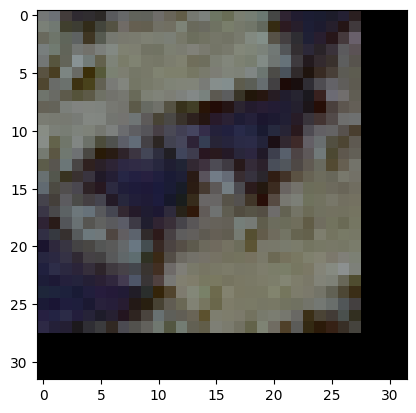

In [7]:
plt.imshow(ex)

In [8]:
ex_label = train_data_label[0]
ex_label

array([0, 0, 1, 0, 0, 0], dtype=uint8)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from sklearn.metrics import accuracy_score

torch.manual_seed(4)

In [10]:
class SatImgDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = T.ToTensor()
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.transform(self.X[index])
        y = torch.FloatTensor(self.y[index])
        return {'x':x, 'y':y}

In [11]:
train_data_reshaped = train_data.reshape(train_qtdy,28,28,4)
test_data_reshaped = test_data.reshape(test_qtdy,28,28,4) 

final_train_data = np.zeros((train_qtdy, 32, 32, 4),dtype=np.float32)
final_train_data[:, :28, :28, :] = train_data_reshaped;

final_test_data = np.zeros((test_qtdy, 32, 32, 4),dtype=np.float32)
final_test_data[:, :28, :28, :] = test_data_reshaped;

In [12]:
dataset_train = SatImgDataset(final_train_data, train_data_label)
dataset_test = SatImgDataset(final_test_data, test_data_label)

loader_train = DataLoader(dataset_train, 512, shuffle=True)
loader_test = DataLoader(dataset_test, 512, shuffle=False)

In [13]:
# Copyright (C) 2023, Advanced Micro Devices, Inc. All rights reserved.
# SPDX-License-Identifier: BSD-3-Clause

from dependencies import value

from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import FloatToIntImplType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType
from brevitas.core.zero_point import ZeroZeroPoint
from brevitas.inject import ExtendedInjector
from brevitas.quant.solver import ActQuantSolver
from brevitas.quant.solver import WeightQuantSolver
from brevitas.quant import Uint8ActPerTensorFloat

class CommonQuant(ExtendedInjector):
    bit_width_impl_type = BitWidthImplType.CONST
    scaling_impl_type = ScalingImplType.CONST
    restrict_scaling_type = RestrictValueType.FP
    zero_point_impl = ZeroZeroPoint
    float_to_int_impl_type = FloatToIntImplType.ROUND
    scaling_per_output_channel = False
    narrow_range = True
    signed = True

    @value
    def quant_type(bit_width):
        if bit_width is None:
            return QuantType.FP
        elif bit_width == 1:
            return QuantType.BINARY
        else:
            return QuantType.INT


class CommonWeightQuant(CommonQuant, WeightQuantSolver):
    scaling_const = 1.0


class CommonUintActQuant(Uint8ActPerTensorFloat):
    """
    Common unsigned act quantizer with bit-width set to None so that it's forced to be specified by
    each layer.
    """
    scaling_min_val = 2e-16
    bit_width = None
    restrict_scaling_type = RestrictValueType.LOG_FP

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.quant.scaled_int import Int8ActPerTensorFloat

bit_quantization = 8

class QuantizedCNN(nn.Module):
    def __init__(self):
        super(QuantizedCNN, self).__init__()
        self.conv1 = qnn.QuantConv2d(
            4, 
            20, 
            kernel_size=3, stride=2, padding=1, 
            bias = False,
            weight_bit_width=bit_quantization, 
            weight_quant=CommonWeightQuant, 
        )
        self.relu1 = qnn.QuantReLU(
            act_quant=CommonUintActQuant,
            bit_width=bit_quantization,
            return_quant_tensor=True
        )
        
        self.conv2 = qnn.QuantConv2d(
            20, 
            8, 
            kernel_size=1, stride=1,
            bias = False,
            weight_bit_width=bit_quantization, 
            weight_quant=CommonWeightQuant, 
        )
        self.relu2 = qnn.QuantReLU(
            act_quant=CommonUintActQuant,
            bit_width=bit_quantization,
            return_quant_tensor=True
        )
        
        self.fc1 = qnn.QuantLinear(
            8*16*16, 
            6, 
            bias = False,
            weight_bit_width=bit_quantization, 
            weight_quant=CommonWeightQuant, 
        )

        # for m in self.modules():
        #     if isinstance(m, qnn.QuantConv2d) or isinstance(m, qnn.QuantLinear):
        #         nn.init.uniform_(m.weight.data, -1, 1)
        #         if m.bias is not None:
        #             nn.init.zeros_(m.bias.data)

    def forward(self, x):
        x = 2.0 * x - torch.tensor([1.0], device=x.device)
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)      
        return x

In [ ]:
%%time
model = QuantizedCNN()
device = torch.device('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 30
criterion = nn.CrossEntropyLoss()
model.train()
i=0
for e in range(epochs):
    if i % 5 == 0:
        print(f"epoch ({i})") 
    for batch in tqdm(loader_train):
        pred = model(batch['x'].to(device))
        loss = criterion(pred, batch['y'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    i+=1

epoch (0)


100%|█████████████████████████████████████████| 633/633 [00:41<00:00, 15.27it/s]


epoch (5)


100%|█████████████████████████████████████████| 633/633 [00:41<00:00, 15.23it/s]


epoch (10)


100%|█████████████████████████████████████████| 633/633 [00:41<00:00, 15.24it/s]


epoch (15)


100%|█████████████████████████████████████████| 633/633 [00:41<00:00, 15.15it/s]


epoch (20)


100%|█████████████████████████████████████████| 633/633 [00:44<00:00, 14.09it/s]


epoch (25)


 84%|██████████████████████████████████▍      | 532/633 [00:35<00:06, 15.27it/s]

In [ ]:
with torch.no_grad():
    correct = 0
    i=0
    for batch in loader_test:
        pred = model(batch['x'].to(device))
        predicted = torch.max(pred, 1)[1]
        real_class = torch.max(batch['y'].to(device), 1)[1]
        correct += (predicted == real_class).sum()
        if (i % 100 == 0):
            print(predicted)
            print(real_class)
        i += 1

print(f"certos: {correct.item()}!!!")
print(f"precisão: {correct.item()/len(dataset_test)*100}%!!!")


In [ ]:
def predict_one_image(model, img_data, y):
    with torch.no_grad():
        pred = model(T.ToTensor()(img_data).unsqueeze(0).to(device))
    true_label = y.argmax()
    pred_label = pred[0].argmax()
    print(pred)
    plt.imshow(img_data.astype(int))
    print("True class: {}, predicted class: {}".format(true_label, pred_label))

In [ ]:
attack_params = {'epsilon':0.02}

image_index = 0

img_data = test_data[image_index].reshape((28,28,4))

ex_img = np.zeros((32, 32, 4),dtype=np.float32)
ex_img[:28, :28, :] = img_data

labels = torch.FloatTensor(test_data_label[image_index]).unsqueeze(0)
predict_one_image(model, ex_img, labels)

In [ ]:
#salvar e carregar o modelo de NN
torch.save(model.state_dict(), "cnn-sat6-w8.pt")

In [ ]:
new_model = QuantizedCNN()
new_model.load_state_dict(torch.load("cnn-sat6-w8.pt"))
predict_one_image(new_model, ex_img, labels)